In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
from numpy import float32
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)
    xmin = int(root.find("object/bndbox/xmin").text)
    ymin = int(root.find("object/bndbox/ymin").text)
    xmax = int(root.find("object/bndbox/xmax").text)
    ymax = int(root.find("object/bndbox/ymax").text)

    return [filename, width, height, xmin, ymin, xmax, ymax]

In [3]:
folder_path = "/kaggle/input/labelled-licensed-number-plate/dataset/train"
xml_files = [file for file in os.listdir(folder_path) if file.endswith(".xml")]

csv_data = []

for xml_file in xml_files:
    xml_path = os.path.join(folder_path, xml_file)
    row_entry = parse_xml(xml_path)
    csv_data.append(row_entry)

In [4]:
csv_file_path = "train_labels.csv"
header = ["filename", "width", "height", "xmin", "ymin", "xmax", "ymax"]

with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(csv_data)

print("CSV file created successfully.")

CSV file created successfully.


In [5]:
def get_bounding_box(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    xmin = int(root.find("object/bndbox/xmin").text)
    ymin = int(root.find("object/bndbox/ymin").text)
    xmax = int(root.find("object/bndbox/xmax").text)
    ymax = int(root.find("object/bndbox/ymax").text)

    return filename, xmin, ymin, xmax, ymax

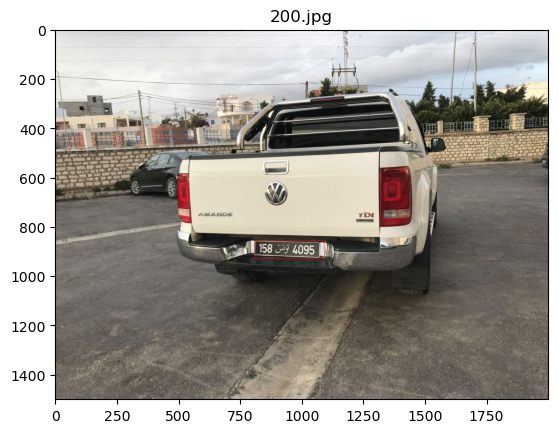

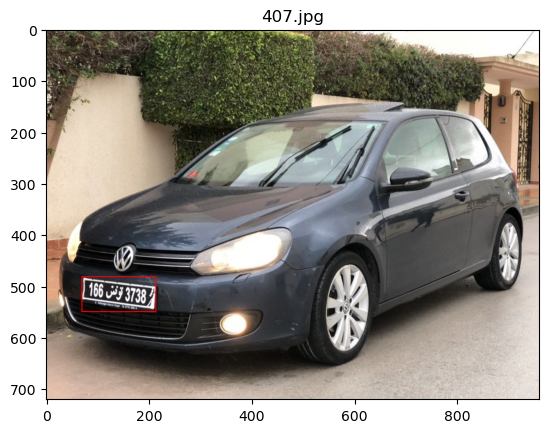

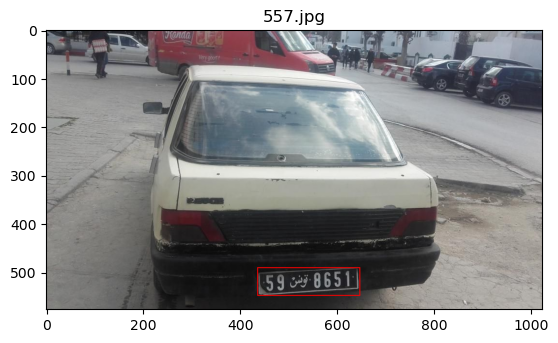

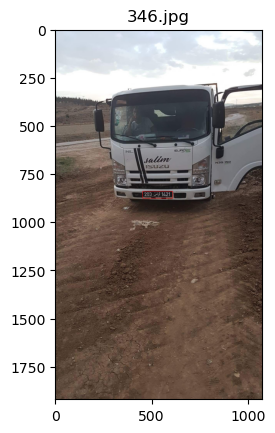

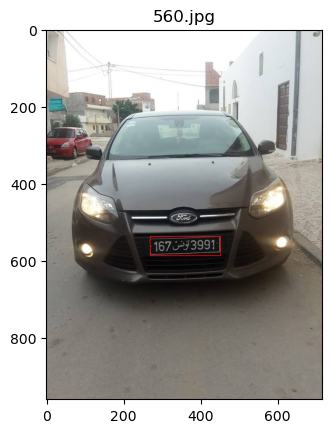

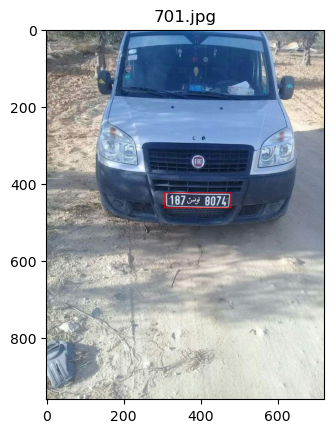

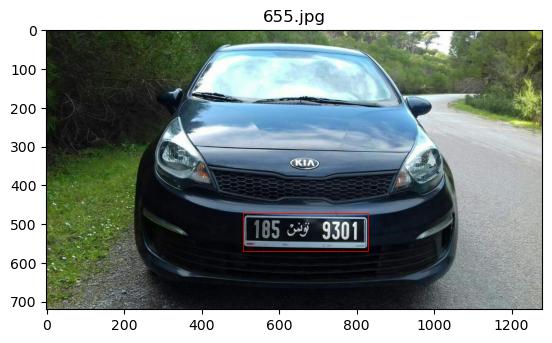

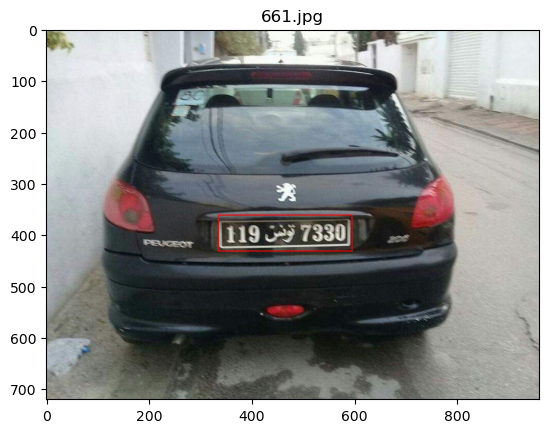

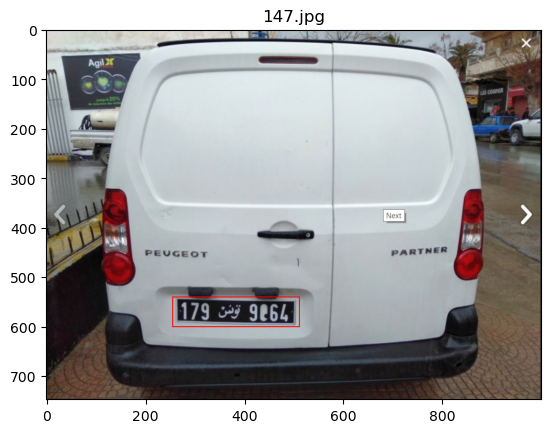

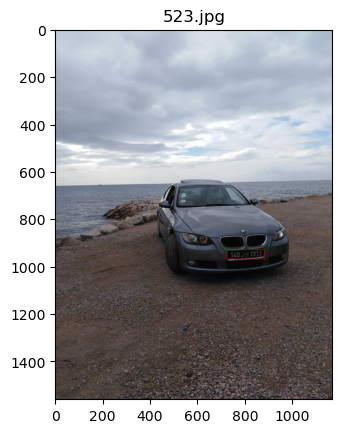

In [6]:
folder_path = "/kaggle/input/labelled-licensed-number-plate/dataset/train"
xml_files = [file for file in os.listdir(folder_path) if file.endswith(".xml")]

for xml_file in xml_files[:10]:
    xml_path = os.path.join(folder_path, xml_file)
    image_file = xml_file.replace(".xml", ".jpg")
    image_path = os.path.join(folder_path, image_file)

    filename, xmin, ymin, xmax, ymax = get_bounding_box(xml_path)

    # Open the image and draw the bounding box
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

    # Display the image with the bounding box using matplotlib
    plt.imshow(img)
    plt.title(filename)
    plt.show()

In [7]:
def preprocess_df(df):
    basefolder='/kaggle/input/labelled-licensed-number-plate/dataset/train/'

    for i, row in df.iterrows():
        filepath= basefolder+row['filename']        
        image=cv2.imread(filepath)
        
        height,width, _ = image.shape
        
        df.at[i,'xmin']=row['xmin']/width
        df.at[i,'ymin']=row['ymin']/height
        df.at[i,'xmax']=row['xmax']/width
        df.at[i,'ymax']=row['ymax']/height   
    
    return df

In [8]:
df=pd.read_csv('train_labels.csv')
df.head(10)

filename  width  height  xmin  ymin  xmax  ymax
0  200.jpg   2000    1500   808   857  1092   930
1  407.jpg    960     720    69   481   214   550
2  557.jpg   1024     576   436   490   648   548
3  346.jpg   1072    1920   453   841   610   878
4  560.jpg    715     960   269   537   452   588
5  701.jpg    720     960   306   424   479   464
6  655.jpg   1280     720   509   473   832   572
7  661.jpg    960     720   335   361   596   432
8  147.jpg   1000     747   255   540   512   601
9  523.jpg   1170    1560   723   928   881   970

In [9]:
df=preprocess_df(df)
df.head(10)

filename  width  height      xmin      ymin      xmax      ymax
0  200.jpg   2000    1500  0.404000  0.571333  0.546000  0.620000
1  407.jpg    960     720  0.071875  0.668056  0.222917  0.763889
2  557.jpg   1024     576  0.425781  0.850694  0.632812  0.951389
3  346.jpg   1072    1920  0.422575  0.438021  0.569030  0.457292
4  560.jpg    715     960  0.376224  0.559375  0.632168  0.612500
5  701.jpg    720     960  0.425000  0.441667  0.665278  0.483333
6  655.jpg   1280     720  0.397656  0.656944  0.650000  0.794444
7  661.jpg    960     720  0.348958  0.501389  0.620833  0.600000
8  147.jpg   1000     747  0.255000  0.722892  0.512000  0.804552
9  523.jpg   1170    1560  0.617949  0.594872  0.752991  0.621795

In [10]:
WIDTH=224
HEIGHT=224

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df,
    directory='/kaggle/input/labelled-licensed-number-plate/dataset/train/',
    x_col='filename',
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/labelled-licensed-number-plate/dataset/train/",
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 454 validated image filenames.
Found 113 validated image filenames.


In [12]:
from tensorflow.keras.applications import InceptionResNetV2

# Load Inception-ResNet-v2 model
model = InceptionResNetV2(include_top=False, weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))

219055592/219055592 [==============================] - 1s 0us/step


In [13]:
# Add custom layers
x = model.output
print(x.shape)
x = Flatten()(x)
print(x.shape)
x = keras.layers.Dense(256, activation='relu')(x)
print(x.shape)
predictions = keras.layers.Dense(4, activation='sigmoid')(x) # 4 is the number of classes
print(predictions.shape)

(None, 5, 5, 1536)
(None, 38400)
(None, 256)
(None, 4)


In [14]:
# Create final model
model = keras.models.Model(inputs=model.input, outputs=predictions)

In [15]:
# Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse')

In [16]:
from tensorflow.keras.callbacks import TensorBoard

tfb = TensorBoard('object_detection')
train=model.fit(train_generator,
                  batch_size=32,
                  epochs=100,
                  validation_data=validation_generator,
                  callbacks=[tfb])

Epoch 1/100
15/15 [==============================] - 120s 797ms/step - loss: 0.0954 - val_loss: 0.0918
Epoch 2/100
15/15 [==============================] - 7s 428ms/step - loss: 0.0762 - val_loss: 0.0708
Epoch 3/100
15/15 [==============================] - 6s 410ms/step - loss: 0.0616 - val_loss: 0.0704
Epoch 4/100
15/15 [==============================] - 6s 406ms/step - loss: 0.0426 - val_loss: 0.0619
Epoch 5/100
15/15 [==============================] - 6s 402ms/step - loss: 0.0177 - val_loss: 0.0353
Epoch 6/100
15/15 [==============================] - 7s 435ms/step - loss: 0.0115 - val_loss: 0.0180
Epoch 7/100
15/15 [==============================] - 6s 402ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 8/100
15/15 [==============================] - 6s 402ms/step - loss: 0.0080 - val_loss: 0.0095
Epoch 9/100
15/15 [==============================] - 6s 402ms/step - loss: 0.0088 - val_loss: 0.0106
Epoch 10/100
15/15 [==============================] - 6s 399ms/step - loss: 0.0082 - val_

In [17]:
model.evaluate_generator(validation_generator)

/tmp/ipykernel_28/3378472596.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator)


0.0031137727200984955

In [18]:
folder_path = "/kaggle/input/labelled-licensed-number-plate/dataset/test"
xml_files = [file for file in os.listdir(folder_path) if file.endswith(".xml")]

csv_data = []

for xml_file in xml_files:
    xml_path = os.path.join(folder_path, xml_file)
    row_entry = parse_xml(xml_path)
    csv_data.append(row_entry)

In [19]:
csv_file_path = "test_labels.csv"
header = ["filename", "width", "height", "xmin", "ymin", "xmax", "ymax"]

with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(csv_data)

print("CSV file created successfully.")

CSV file created successfully.


**Test Images**

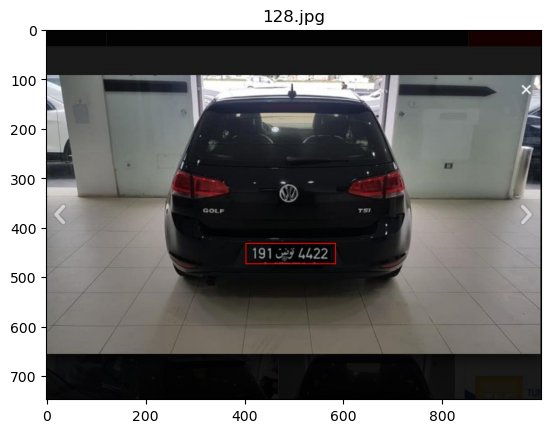

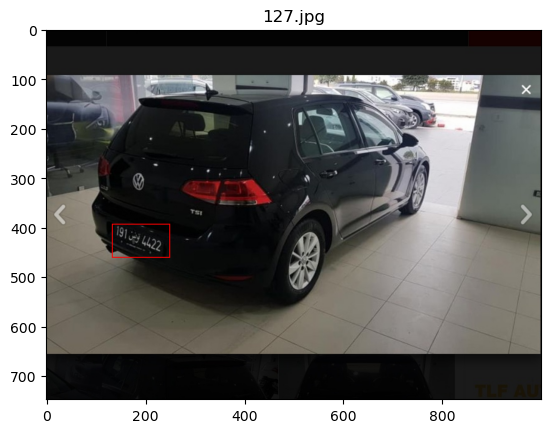

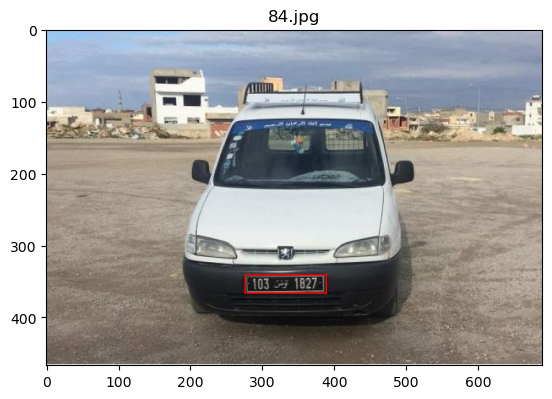

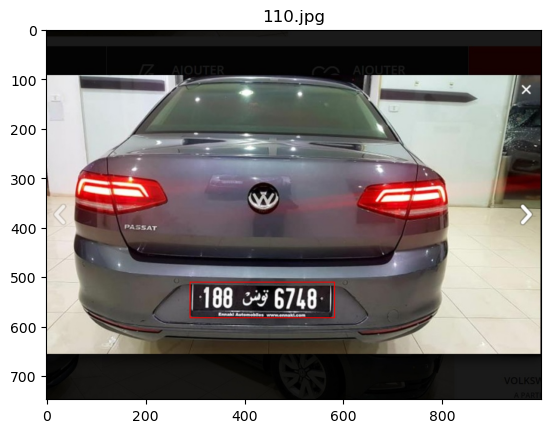

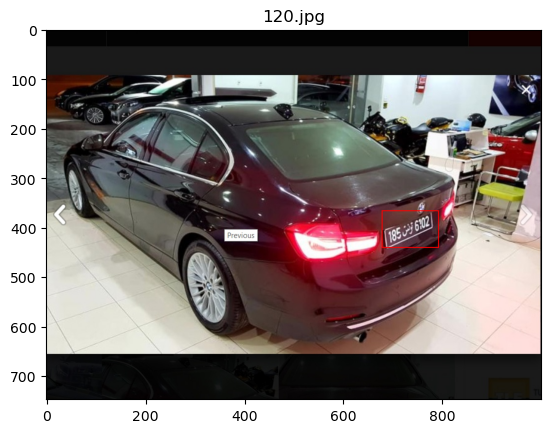

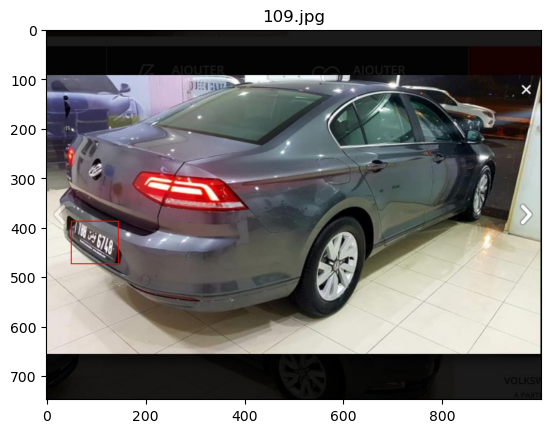

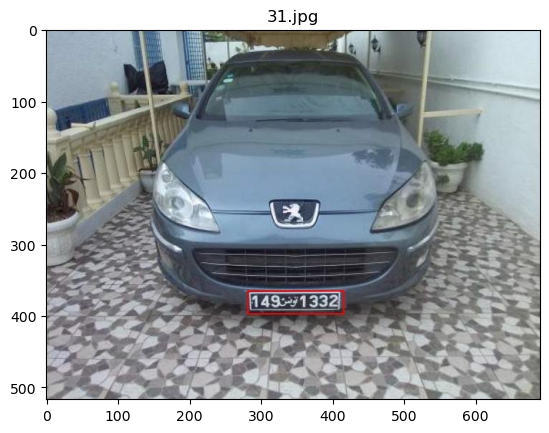

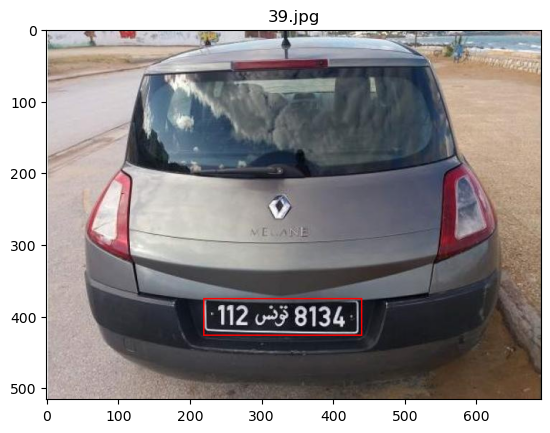

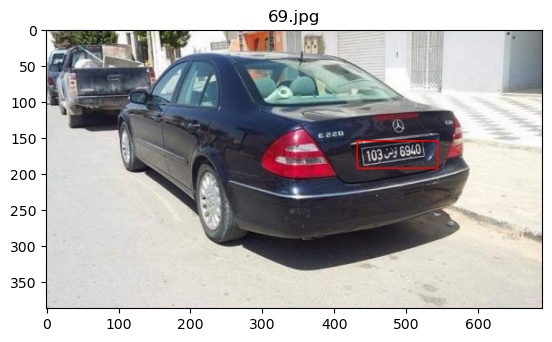

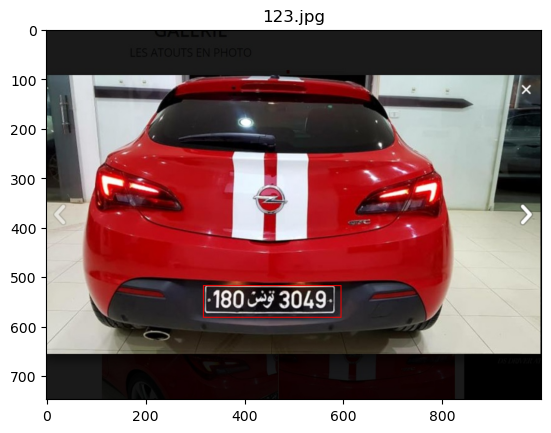

In [20]:
folder_path = "/kaggle/input/labelled-licensed-number-plate/dataset/test"
xml_files = [file for file in os.listdir(folder_path) if file.endswith(".xml")]

for xml_file in xml_files[:10]:
    xml_path = os.path.join(folder_path, xml_file)
    image_file = xml_file.replace(".xml", ".jpg")
    image_path = os.path.join(folder_path, image_file)

    filename, xmin, ymin, xmax, ymax = get_bounding_box(xml_path)

    # Open the image and draw the bounding box
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

    # Display the image with the bounding box using matplotlib
    plt.imshow(img)
    plt.title(filename)
    plt.show()

In [21]:
# Function to extract alphanumeric text from OCR result
def extract_alphanumeric(text):
    return re.sub(r'[^a-zA-Z0-9]', '', text)

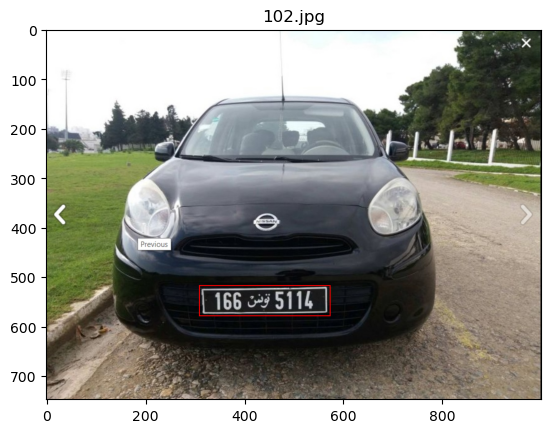

OCR Text (Alphanumeric Only): 16635114


In [22]:
import pytesseract as pt
import re

image_path = '/kaggle/input/labelled-licensed-number-plate/dataset/test/102.jpg'
xml_path = '/kaggle/input/labelled-licensed-number-plate/dataset/test/102.xml'

filename, xmin, ymin, xmax, ymax = get_bounding_box(xml_path)

img = Image.open(image_path)
draw = ImageDraw.Draw(img)
draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

plt.imshow(img)
plt.title(filename)
plt.show()
    
roi = img.crop((xmin, ymin, xmax, ymax))
text = pt.image_to_string(roi, config='--psm 6')
alphanumeric_text = extract_alphanumeric(text)
    
print("OCR Text (Alphanumeric Only):", alphanumeric_text)